In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import numpy as np
import math
import tensorflow as tf
import mediapipe as mp
from collections import deque
import time
import os

In [ ]:
# ---------------- CONFIG ----------------
VIDEO_PATH = "/content/Himanshu_New_Dataset.mp4"
SEQUENCE_LENGTH = 10
IMG_HEIGHT, IMG_WIDTH = 64, 64
CHANNELS = 1
SAVE_PATH = "dataset_features"
os.makedirs(SAVE_PATH, exist_ok=True)

In [ ]:
EAR_THRESHOLD = 0.25
MOR_THRESHOLD = 0.6
NLR_THRESHOLD = 0.35
SHOW_OVERLAY = True


In [ ]:
# ---------------- LANDMARK INDICES ----------------
# Eyes
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

# Mouth: use upper/lower center + corners for MOR
MOUTH_VERTICAL = [13, 14]      # upper lip, lower lip
MOUTH_HORIZONTAL = [78, 308]   # left corner, right corner

# Nose: tip and bridge/root for NLR
NOSE_POINTS = [1, 4, 98, 327]  # vertical: 1-4, horizontal: 98-327

In [ ]:
# MediaPipe setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False,
                                  max_num_faces=1,
                                  refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)


In [ ]:
# ---------------- UTILITIES ----------------
def euclidean(p1, p2):
    return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

def eye_aspect_ratio(eye_landmarks):
    A = euclidean(eye_landmarks[1], eye_landmarks[5])
    B = euclidean(eye_landmarks[2], eye_landmarks[4])
    C = euclidean(eye_landmarks[0], eye_landmarks[3])
    return (A + B) / (2.0 * C)

def mouth_opening_ratio(landmarks):
    A = euclidean(landmarks[MOUTH_VERTICAL[0]], landmarks[MOUTH_VERTICAL[1]])
    B = euclidean(landmarks[MOUTH_HORIZONTAL[0]], landmarks[MOUTH_HORIZONTAL[1]])
    return A / B

def nose_length_ratio(landmarks):
    # vertical / horizontal
    A = euclidean(landmarks[NOSE_POINTS[0]], landmarks[NOSE_POINTS[1]])
    B = euclidean(landmarks[NOSE_POINTS[2]], landmarks[NOSE_POINTS[3]])
    return A / B

def extract_eye_region(frame, landmarks, indices):
    h, w, _ = frame.shape
    xs = [int(landmarks[i].x * w) for i in indices]
    ys = [int(landmarks[i].y * h) for i in indices]
    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)
    eye_img = frame[y1:y2, x1:x2]
    eye_img = cv2.resize(eye_img, (IMG_WIDTH, IMG_HEIGHT))
    # convert to grayscale
    eye_img = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)
    # normalize to [0,1]
    eye_img = eye_img / 255.0
    return eye_img



In [ ]:
# ---------------- FEATURE EXTRACTION ----------------
frames = []
numeric_features = []
labels = []

cap = cv2.VideoCapture(VIDEO_PATH)
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False,
                                  max_num_faces=1,
                                  refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark

        # Eyes
        left_eye = [landmarks[i] for i in LEFT_EYE]
        right_eye = [landmarks[i] for i in RIGHT_EYE]
        ear = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) / 2.0

        # Mouth
        mor = mouth_opening_ratio(landmarks)

        # Nose
        nlr = nose_length_ratio(landmarks)

        # Eye images
        left_eye_img = extract_eye_region(frame, landmarks, LEFT_EYE)
        right_eye_img = extract_eye_region(frame, landmarks, RIGHT_EYE)
        avg_eye = (left_eye_img + right_eye_img) / 2.0

        frames.append(avg_eye.reshape(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
        numeric_features.append([ear, mor, nlr])
        labels.append(1 if ear < EAR_THRESHOLD else 0)

cap.release()


In [ ]:
# ---------------- CREATE SEQUENCES ----------------
sequence_images = []
sequence_numeric = []
sequence_labels = []

for i in range(len(frames) - SEQUENCE_LENGTH):
    sequence_images.append(frames[i:i+SEQUENCE_LENGTH])
    sequence_numeric.append(numeric_features[i:i+SEQUENCE_LENGTH])
    sequence_labels.append(labels[i + SEQUENCE_LENGTH - 1])

X_images = np.array(sequence_images)
X_numeric = np.array(sequence_numeric)
y = np.array(sequence_labels)

In [ ]:
# ---------------- CNN+LSTM MODEL ----------------
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

In [ ]:
# Image branch
image_input = Input(shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = TimeDistributed(Conv2D(32, (3,3), activation='relu'))(image_input)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(64, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(64, return_sequences=False)(x)


In [ ]:
# Numeric branch
numeric_input = Input(shape=(SEQUENCE_LENGTH, 3))
y_branch = LSTM(32, return_sequences=False)(numeric_input)

# Merge branches
combined = Concatenate()([x, y_branch])
z = Dropout(0.5)(combined)
output = Dense(1, activation='sigmoid')(z)

In [ ]:
model = Model(inputs=[image_input, numeric_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 10, 62,    │        320 │ input_layer_2[0]… │
│ (TimeDistributed)   │ 62, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 10, 31,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 31, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 10, 29,    │     18,496 │ time_distributed… │
│ (TimeDistributed)   │ 29, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 10, 14,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 14, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 10, 12544) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │  3,227,904 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │      4,608 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 96)        │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         97 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,251,425 (12.40 MB)

 Trainable params: 3,251,425 (12.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ---------------- TRAIN ----------------
history = model.fit([X_images, X_numeric], y, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7987 - loss: 0.4476 - val_accuracy: 0.9263 - val_loss: 0.2046
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9398 - loss: 0.1479 - val_accuracy: 0.9789 - val_loss: 0.0814
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9503 - loss: 0.1266 - val_accuracy: 0.9632 - val_loss: 0.1105
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9618 - loss: 0.0864 - val_accuracy: 0.9789 - val_loss: 0.0821
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9663 - loss: 0.0893 - val_accuracy: 0.9737 - val_loss: 0.0797
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9689 - loss: 0.0750 - val_accuracy: 0.9579 - val_loss: 0.1137
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9767 - loss: 0.0723 - val_accuracy: 0.9789 - val_loss: 0.0725
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9779 - loss: 0.0670 - val_accuracy: 0.9789 - v

In [ ]:
# ----------------- SAVE MODEL -----------------
model.save("cnn_lstm_all_features_05_sept_drowsiness.h5")
print("Model saved as cnn_lstm_drowsiness.h5")

Model saved as cnn_lstm_drowsiness.h5


In [ ]:
import matplotlib.pyplot as plt


Graphs, confusion matrix and all

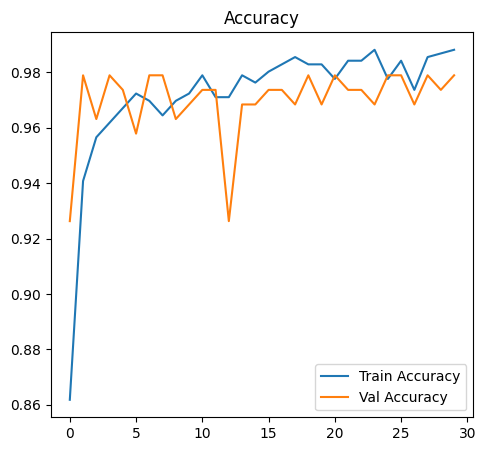

In [ ]:
# ---------------- PLOT GRAPHS ----------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

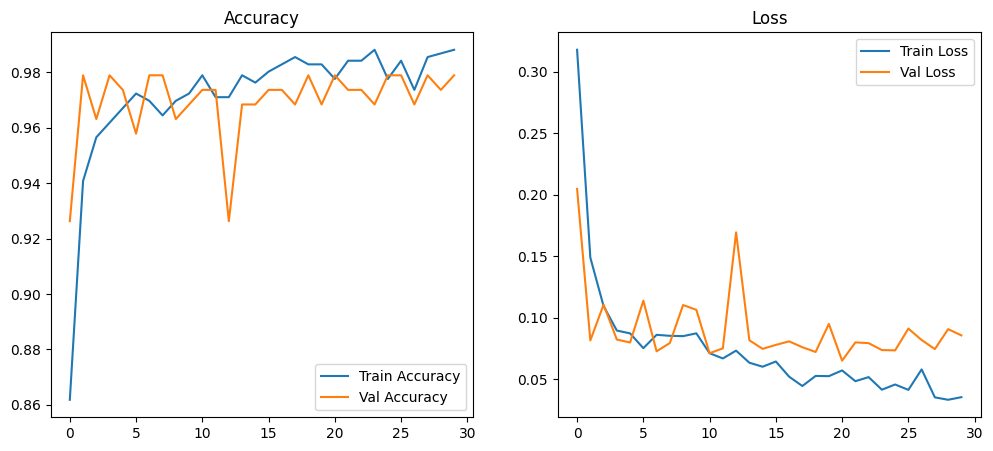

In [ ]:
# ---------------- PLOT GRAPHS ----------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Confusion Matrix:
[[242   5]
 [  4 699]]
Classification Report:
              precision    recall  f1-score   support

       Awake       0.98      0.98      0.98       247
      Drowsy       0.99      0.99      0.99       703

    accuracy                           0.99       950
   macro avg       0.99      0.99      0.99       950
weighted avg       0.99      0.99      0.99       950



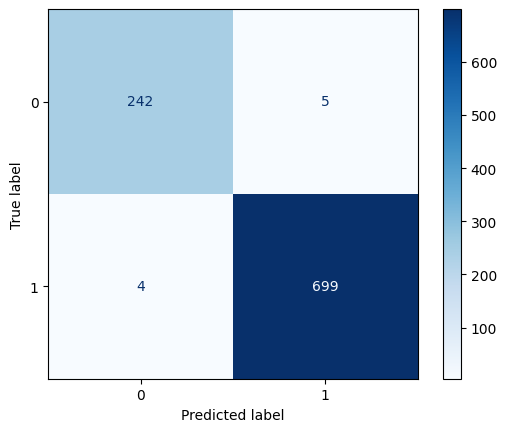

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ---------------- PREDICTIONS ----------------
y_pred_prob = model.predict([X_images, X_numeric])
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # threshold 0.5

# ---------------- CONFUSION MATRIX ----------------
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')

# ---------------- CLASSIFICATION REPORT ----------------
report = classification_report(y, y_pred, target_names=['Awake', 'Drowsy'])
print("Classification Report:")
print(report)
